In [ ]:
import pandas as pd
import numpy as np
from matplotlib import rc
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
import random


In [48]:
# 랜덤 시드 고정
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)
random.seed(SEED)

In [ ]:
df = pd.read_csv('아파트매매지수예측_변수.csv')

,Unnamed: 0,아파트매매지수,부동산심리지수,kospi,소비자물가지수,New_COFIX,Outstanding_COFIX,실업률,아파트거래량,지가변동률
0,2011년 7월,80.0,122.9,2120.03,88.654,3.42,3.69,4.2,4096,0.067
1,2011년 8월,80.2,128.3,2160.09,89.250,3.52,3.73,4.3,4931,0.052
2,2011년 9월,80.0,121.7,1887.21,89.164,3.56,3.74,4.4,4868,0.049
3,2011년 10월,79.4,109.2,1683.94,89.079,3.54,3.76,4.0,4701,0.043
4,2011년 11월,78.6,100.4,1891.22,89.079,3.59,3.78,4.0,4568,0.037
...,...,...,...,...,...,...,...,...,...,...
153,2024년 4월,160.0,110.0,2766.24,113.370,3.71,3.95,3.6,4840,0.238
154,2024년 5월,161.4,113.0,2679.04,113.420,3.70,3.96,3.6,5182,0.246
155,2024년 6월,164.1,120.1,2657.81,113.170,3.77,3.96,3.3,6150,0.269
156,2024년 7월,167.6,123.5,2792.96,113.460,3.80,3.95,2.6,9518,0.282


In [50]:
# 날짜변수 Datetime으로 변환 (시계열 고려)
# df['날짜'] = pd.to_datetime(df['Unnamed: 0'], format='%Y년 %m월')

# 날짜 변수 제거
df = df.drop(columns = 'Unnamed: 0')

# 모멘텀 만들 때, 거래량 0이면 inf값 발생 => 아파트 거래량이 0이 애들 10.00001로 변경
df['아파트거래량'] = np.where(df['아파트거래량']==0, 0.00001, df['아파트거래량'])

In [52]:
# 방향성 y값 생성
df['방향성'] = (df['아파트매매지수'].diff() > 0).astype(int) # 1 if increase, 0 if decrease
df['방향성'] = df['방향성'].shift(-1)

# df = df.dropna()

In [ ]:
columns = df.drop(columns=["방향성"]).columns

Index(['아파트매매지수', '부동산심리지수', 'kospi', '소비자물가지수', 'New_COFIX',
       'Outstanding_COFIX', '실업률', '아파트거래량', '지가변동률'],
      dtype='object')

In [ ]:
# 변동성 특성 추가

lags = [1, 3, 6, 12]  # 시차 변수: 1개월 전, 3개월 전, 6개월 전, 12개월 전


# 변수 생성
for col in columns:
    # 변화율
    df[f'{col}_변화율'] = df[col].pct_change(fill_method=None).fillna(0)
    # 이동평균
    df[f'{col}_이동평균'] = df[col].rolling(window=3, min_periods=1).mean()
    # 변동성
    df[f'{col}_변동성'] = df[col].rolling(window=5, min_periods=1).std().bfill()
    # 모멘텀
    df[f'{col}_모멘텀'] = df[col].pct_change(periods=3, fill_method=None).fillna(0)
    # 시차 변수 생성
    for lag in lags:
        df[f'{col}_lag{lag}'] = df[col].shift(lag)

# NA 값 제거
df2 = df.copy()
df = df.dropna()

,아파트매매지수,부동산심리지수,kospi,소비자물가지수,New_COFIX,Outstanding_COFIX,실업률,아파트거래량,지가변동률,방향성,...,아파트거래량_lag6,아파트거래량_lag12,지가변동률_변화율,지가변동률_이동평균,지가변동률_변동성,지가변동률_모멘텀,지가변동률_lag1,지가변동률_lag3,지가변동률_lag6,지가변동률_lag12
12,74.2,96.5,1864.73,90.305,3.69,3.83,4.2,2952.0,-0.032,0.0,...,1536.0,4096.0,-1.551724,0.040000,0.056805,-1.307692,0.058,0.104,0.031,0.067
13,73.6,102.9,1870.58,90.842,3.70,3.80,4.2,2398.0,-0.057,0.0,...,3512.0,4931.0,0.781250,-0.010333,0.073674,-1.606383,-0.032,0.094,0.045,0.052
14,73.2,106.5,1909.06,91.455,3.56,3.76,4.0,2227.0,-0.055,0.0,...,4087.0,4868.0,-0.035088,-0.048000,0.069795,-1.948276,-0.057,0.058,0.098,0.049
15,73.0,109.8,1998.52,91.225,3.44,3.73,3.6,4239.0,0.011,0.0,...,4214.0,4701.0,-1.200000,-0.033667,0.049138,-1.343750,-0.055,-0.032,0.104,0.043
16,72.8,104.2,1903.57,90.867,3.56,3.71,3.6,5069.0,0.031,0.0,...,3785.0,4568.0,1.818182,-0.004333,0.039684,-1.543860,0.011,-0.057,0.094,0.037
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
152,159.0,106.8,2664.52,113.020,3.69,3.95,3.4,3482.0,0.226,1.0,...,3845.0,3234.0,0.430380,0.180333,0.034507,0.170984,0.158,0.193,0.205,-0.008
153,160.0,110.0,2766.24,113.370,3.71,3.95,3.6,4840.0,0.238,1.0,...,2983.0,2981.0,0.053097,0.207333,0.037501,0.515924,0.226,0.157,0.251,-0.004
154,161.4,113.0,2679.04,113.420,3.70,3.96,3.6,5182.0,0.246,1.0,...,2417.0,3711.0,0.033613,0.236667,0.043943,0.556962,0.238,0.158,0.227,0.052
155,164.1,120.1,2657.81,113.170,3.77,3.96,3.3,6150.0,0.269,1.0,...,1790.0,4136.0,0.093496,0.251000,0.041855,0.190265,0.246,0.226,0.193,0.065


In [55]:
X = df.drop(columns = ['방향성', '아파트매매지수'])
y = df['방향성']

In [56]:
# train_test분리
train_size = int(len(X) * 0.7) 
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]
X_train.shape, X_test.shape, y_train.shape, y_test.shape

# # 데이터 분리 비율 설정
# train_size = int(len(X) * 0.7)  # 70% Train
# val_size = int(len(X) * 0.15)  # 15% Validation
# test_size = len(X) - train_size - val_size  # 나머지 15% Test

# # 데이터 분리
# X_train, X_val, X_test = X[:train_size], X[train_size:train_size + val_size], X[train_size + val_size:]
# y_train, y_val, y_test = y[:train_size], y[train_size:train_size + val_size], y[train_size + val_size:]

# # 각 데이터셋 크기 확인
# X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape


((101, 80), (44, 80), (101,), (44,))

In [57]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [76]:
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, f1_score

# TimeSeriesSplit 객체 생성
tscv = TimeSeriesSplit(n_splits=4)  # 5개 분할로 시계열 교차 검증

# 하이퍼파라미터 설정
param_grid = {
    'n_estimators': [100, 200, 300, 500],  # 트리 개수 (추가: 500, 1000)
    'max_depth': [None, 10, 20, 30],        # 트리 최대 깊이 (추가: 30, 50)
    'min_samples_split': [2, 5, 10],        # 노드 분할 최소 샘플 수 (추가: 10, 20)
    'min_samples_leaf': [1, 2, 4],           # 리프 노드 최소 샘플 수 (추가: 4, 8)
}

# RandomForestClassifier 초기화
rf = RandomForestClassifier(random_state=42)

# GridSearchCV 초기화
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    scoring='f1',   # 평가 기준
    cv=tscv,              # TimeSeriesSplit 사용
    verbose=2,            # 진행 상황 출력
    n_jobs=-1             # 병렬 처리
)

# GridSearchCV 실행 (Train 데이터에 대해 수행)
grid_search.fit(X_train, y_train)

Fitting 4 folds for each of 144 candidates, totalling 576 fits
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.2s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.2s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=   0.2s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.2s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.2s
[CV] END m

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=4, test_size=None),
             estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [None, 10, 20, 30],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 300, 500]},
             scoring='f1', verbose=2)

In [ ]:
# # 최적의 하이퍼파라미터와 점수 출력
# print("Best Parameters:", grid_search.best_params_)
# print("Best Cross-Validation Accuracy:", grid_search.best_score_)


Best Parameters: {'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}
Best Cross-Validation Accuracy: 0.8895132645132645


In [78]:
# Validation 데이터 평가 (최적의 모델 사용)
best_model = grid_search.best_estimator_
y_test_pred = best_model.predict(X_test)
print("\nTest Accuracy:", accuracy_score(y_test, y_test_pred))
print("\nTest F1_Score:", f1_score(y_test, y_test_pred))
print("\nTest Classification Report:\n", classification_report(y_test, y_test_pred))


Test Accuracy: 0.8409090909090909

Test F1_Score: 0.8888888888888888

Test Classification Report:
               precision    recall  f1-score   support

         0.0       0.82      0.64      0.72        14
         1.0       0.85      0.93      0.89        30

    accuracy                           0.84        44
   macro avg       0.83      0.79      0.80        44
weighted avg       0.84      0.84      0.84        44



Text(50.722222222222214, 0.5, 'True Label')

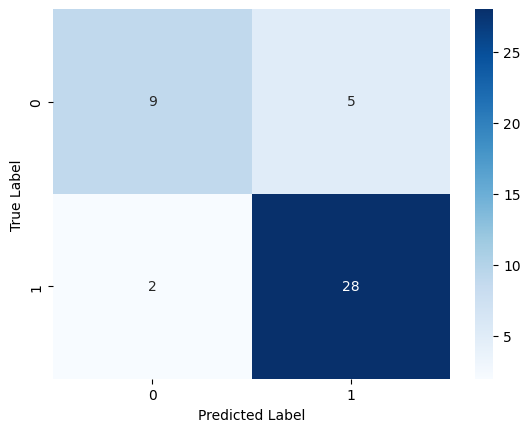

In [ ]:
# cf = confusion_matrix(y_test, y_test_pred)

# sns.heatmap(cf, annot=True, cmap='Blues')
# plt.xlabel('Predicted Label')
# plt.ylabel('True Label')

In [82]:
tmp = df2.drop(columns=['방향성', '아파트매매지수'])

X_future = tmp.loc[[157]]

In [81]:
best_model.predict(X_future)

/Users/baehuijin/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


array([0.])